!pip install --q openai langchain_community

!pip install langchain_openai

In [2]:
import dotenv
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")

#load environment variables from .env file
dotenv.load_dotenv()

# _set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("OPENAI_API_KEY")

# Optional, add tracing in LangSmith.
# This will help you visualize and debug the control flow
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Langraph chatbot"

In [3]:
from typing import List

import openai

#define your agent
def my_chat_bot(messages: List[dict]) -> dict:
    system_message = {
        "role": "system",
        "content": "You are a customer support agent for a product company.",
    }
    messages = [system_message] + messages
    completion = openai.chat.completions.create(
        messages=messages, model="gpt-3.5-turbo"
    )
    return completion.choices[0].message.model_dump()

In [4]:
my_chat_bot([{"role": "user", "content": "hi!"}])

{'content': 'Hello! How can I assist you today?',
 'role': 'assistant',
 'function_call': None,
 'tool_calls': None}

!pip install langgraph

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import chain
from langchain_openai import ChatOpenAI

system_prompt_template = """You are a customer of a company who sells charging fans. \
You are interacting with a user who is a customer support person. \

{instructions}

When you are finished with the conversation, respond with a single word 'TERMINATE'"""

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt_template),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
instructions = """Your name is Mahesh. You are trying to get a refund for the charging fan. \
You want them to give you ALL the money back. \
You bought the fane 2 days back. \
And it is not working properly."""

prompt = prompt.partial(name="Mahesh", instructions=instructions)

model = ChatOpenAI()

simulated_user = prompt | model

In [6]:
from langchain_core.messages import HumanMessage


messages = [HumanMessage(content="Hi! How can I help you?")]
simulated_user.invoke({"messages": messages})

AIMessage(content="Hi, I purchased one of your charging fans two days ago, but unfortunately, it's not working properly. I would like to request a refund, please.", response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 109, 'total_tokens': 141}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-febbeaf3-837a-471f-8440-cccc454f680a-0', usage_metadata={'input_tokens': 109, 'output_tokens': 32, 'total_tokens': 141})

In [7]:
from langchain_core.messages import AIMessage
from langchain_community.adapters.openai import convert_message_to_dict


def chat_bot_node(messages):
    # Convert from LangChain format to the OpenAI format, which our chatbot function expects.
    messages = [convert_message_to_dict(m) for m in messages]
    # Call the chat bot
    chat_bot_response = my_chat_bot(messages)
    # Respond with an AI Message
    return AIMessage(content=chat_bot_response["content"])

In [8]:
def _swap_roles(messages):
    new_messages = []
    for m in messages:
        if isinstance(m, AIMessage):
            new_messages.append(HumanMessage(content=m.content))
        else:
            new_messages.append(AIMessage(content=m.content))
    return new_messages


def simulated_user_node(messages):
    # Swap roles of messages
    new_messages = _swap_roles(messages)
    # Call the simulated user
    response = simulated_user.invoke({"messages": new_messages})
    # This response is an AI message - we need to flip this to be a human message
    return HumanMessage(content=response.content)

In [9]:
def should_continue(messages):
    if len(messages) > 6:
        return "end"
    elif messages[-1].content == "TERMINATE":
        return "end"
    else:
        return "continue"

In [12]:
from langgraph.graph import END, MessageGraph
from langgraph.checkpoint.sqlite import SqliteSaver

graph_message = MessageGraph()

graph_message.add_node("user", simulated_user_node)
graph_message.add_node("chatbot", chat_bot_node)

# The input will first go to your chat bot
graph_message.set_entry_point("chatbot")

# simulated user
graph_message.add_edge("chatbot", "user")
graph_message.add_conditional_edges(
    "user",
    should_continue,
    # If the finish criteria are met, we will stop the simulation,
    # otherwise, the virtual user's message will be sent to your chat bot
    {
        "end": END,
        "continue": "chatbot",
    },
)

#graph_message.add_edge("generate", END)

memory = SqliteSaver.from_conn_string(":memory:")
graph_1 = graph_message.compile(checkpointer=memory)

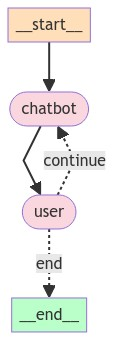

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph_1.get_graph(xray=True).draw_mermaid_png()))
except:
    # This requires some extra dependencies and is optional
    pass

In [14]:
for chunk in graph_1.stream([]):
    # Print out all events aside from the final end chunk
    if END not in chunk:
        print(chunk)
        print("----")

ValueError: Checkpointer requires one or more of the following 'configurable' keys: ['thread_id', 'thread_ts']